Using function from R in python, to fit if the model is not already stored, this first piece of code must always be run first. R 4.4.* must be used. 

In [ ]:
import os
import sys
import platform

# Detectar OS
if platform.system() == 'Windows':
    # Define dónde está R
    R_HOME = r"C:\Program Files\R\R-4.4.3"  # adapta si es otro servidor
    os.environ['R_HOME'] = R_HOME

    # Si Python ≥ 3.8, añade directorios de DLL
    if sys.version_info >= (3, 8):
        os.add_dll_directory(os.path.join(R_HOME, 'bin'))      # carpeta core
        os.add_dll_directory(os.path.join(R_HOME, 'bin', 'x64'))  # carpeta 64‑bit
        os.environ['PATH'] = os.path.join(R_HOME, 'bin', 'x64') + ';' + os.environ['PATH']
    else:
        # Python <3.8: solo PATH
        os.environ['PATH'] = (
            os.path.join(R_HOME, 'bin', 'x64') + ';' +
            os.environ.get('PATH', '') + ';' + 
            os.environ['PATH']
        )
        
else:
    # Linux / macOS: ajusta LD_LIBRARY_PATH
    R_HOME = '/usr/lib/R'
    os.environ['R_HOME'] = R_HOME
    os.environ['LD_LIBRARY_PATH'] = f"{R_HOME}/lib{os.pathsep}" + os.environ.get('LD_LIBRARY_PATH', '')




Example to check that R function is working correctly, take into account that models are fitted and stored as used, therefore will take more time when working with new zones that are not already stored (1-90 secs) but will be very fast for zone models that have already been used (<1 sec)

In [9]:
import rpy2.robjects as ro




ro.r['source']('my_r_functions.R')
# Get the R function
predict = ro.globalenv['predict_demand_at_time']

# Call it, NOTE: (rpy2 will auto‐convert Python int -> R integer and str -> R character)
zone_id       = 50
forecast_time = "2024-02-05 12:00"

res = predict(zone_id, forecast_time)

# Convert the single‐element R vector to a Python float
predicted_demand = float(res[0])

print(f"Predicted hourly demand for zone {zone_id} at {forecast_time}: {predicted_demand}")

Predicted hourly demand for zone 50 at 2024-02-05 12:00: 24.530585888330616


Here we work on putting everything together as a function that decides where the taxist has to go, and we run a simulation to get some results for average daily revenue earned on a month say e.g. January to compare.


First we build the function that chooses the best zone to go to.

In [10]:
import numpy as np
import pandas as pd
from datetime import timedelta

def choose_best_next_zone(current_zone: int,
                          current_datetime: pd.Timestamp,
                          prob_matrix: np.ndarray,
                          fare_matrix: np.ndarray,
                          time_dist_matrix: np.ndarray,
                          predict_demand,
                          epsilon: float = 1e-6) -> int:
    """
    Returns the best next zone for a taxi in `current_zone` at `current_datetime`.
    
    Parameters
    ----------
    current_zone : int
        Zone index (should match your matrices; e.g. 1..265).
    current_datetime : pd.Timestamp
        Current date and time.
    prob_matrix : np.ndarray, shape=(266,266,24)
        P(dropoff=j | pickup=i, hour=h).
    fare_matrix : np.ndarray, shape=(266,266,24)
        Average fare for trips i→j at hour h.
    time_dist_matrix : np.ndarray, shape=(266,266,4)
        [avg_time_min, std_time_min, avg_dist_km, std_dist_km].
    predict_demand : Callable[[int, pd.Timestamp], float]
        Function returning expected demand at a zone and datetime.
    epsilon : float
        Small constant to avoid division by zero.
    
    Returns
    -------
    best_zone : int
        The zone index (0..265) that maximizes our utility function.
    """
    # Extract the current hour 0–23
    hour = current_datetime.hour
    
    # Pre‐allocate utility scores
    num_zones = prob_matrix.shape[0]
    utilities = np.full(num_zones, -np.inf, dtype=np.float64)
    
    # For each candidate drop‐off zone j
    for j in range(num_zones):
        # probability of a paying trip i→j at this hour
        p_ij = prob_matrix[current_zone, j, hour]
        # average fare
        f_ij = fare_matrix[current_zone, j, hour]
        # average deadhead travel time (in minutes)
        t_avg_min = time_dist_matrix[current_zone, j, 0]
        
        # Skip if no chance of trip or no time estimate
        if np.isnan(p_ij) or np.isnan(f_ij) or np.isnan(t_avg_min) or p_ij <= 0:
            continue
        
        # Convert travel time to hours
        t_hours = t_avg_min / 60.0
        
        # Predict future demand at zone j when we'll arrive
        arrival_time = current_datetime + timedelta(minutes=float(t_avg_min))
        
        demand_j = predict_demand(j, arrival_time)
        
        # Utility: expected revenue × future demand, penalized by deadhead time
        utilities[j] = (p_ij * f_ij * demand_j) / (t_hours + epsilon)
    
    # If all utilities are -inf (no valid moves), stay in place
    if np.all(np.isneginf(utilities)):
        return current_zone
    
    # Otherwise pick the argmax
    best_zone = int(np.nanargmax(utilities))
    return best_zone





In [5]:
# Example usage of the function
import rpy2.robjects as ro




ro.r['source']('my_r_functions.R')
# Get the R function
predict_r = ro.globalenv['predict_demand_at_time']

def predict_demand(zone: int, ts: pd.Timestamp) -> float:
    # Convert pandas.Timestamp to R POSIXct
    r_zone = ro.IntVector([zone])
    r_time = ro.POSIXct([ts.to_pydatetime()])
   
    # Call the R function
    result = predict_r(r_zone, r_time)
    
    # Convert to float (assuming single value return)
    return float(result[0])


# Load your matrices
prob_matrix      = np.load("zone_transition_probabilities_2024.npy")
fare_matrix      = np.load("zone_avg_earnings_2024.npy")
time_dist_matrix = np.load("intra_zone_matrix.npy")



current_zone     = 125
current_datetime = pd.Timestamp("2024-08-15 14:23:00")

next_zone = choose_best_next_zone(
    current_zone,
    current_datetime,
    prob_matrix,
    fare_matrix,
    time_dist_matrix,
    predict_demand
)

print(f"Best next zone from {current_zone} at {current_datetime} → {next_zone}")

Best next zone from 125 at 2024-08-15 14:23:00 → 238


The following code is based on a month, to compare the hourly revenue using the program compared to in real life data. What this does is it simulates the taxist through the given months database, that is it only takes trips that are stored in the database, this is detrimental to our model since our simulated taxi may arrive to a zone and wait for e.g. 15 minutes then accepts the trip taken from the database, but in real life there is a high possibility that the person that is picked up, that was waiting for the taxi, was waiting for a certain amount of time before they where picked up according to the database.

Therefore, this is useful to compare with real life but note that to compare with other models a normal completely simulated environment using the transition matrices created must be done.

In [17]:
import pandas as pd
import numpy as np
from datetime import timedelta
import bisect
from typing import Callable, Dict, Tuple, Optional, List

def prepare_trip_lookup(df: pd.DataFrame) -> Tuple[Dict[int, dict], pd.Timestamp]:
    """
    Build a fast lookup for next-trip searches and return the latest pickup time:
      - lookup: { zone: { "times": np.ndarray[timestamps],
                          "records": pd.DataFrame } }
      - max_pickup: latest datetime in df for ending the sim
    """
    lookup: Dict[int, dict] = {}
    for zone, sub in df.groupby('PULocationID'):
        sub = sub.sort_values('tpep_pickup_datetime').reset_index(drop=True)
        lookup[int(zone)] = {
            "times": sub['tpep_pickup_datetime'].values,
            "records": sub
        }
    max_pickup = df['tpep_pickup_datetime'].max()
    return lookup, max_pickup


def simulate_driver(
    prob_matrix: np.ndarray,
    fare_matrix: np.ndarray,
    time_dist_matrix: np.ndarray,
    trip_lookup: Dict[int, dict],
    max_pickup: pd.Timestamp,
    predict_demand: Callable[[int, pd.Timestamp], float],
    work_hours_per_day: float = 6.7,
    total_work_days: float = 21.7,
    seed: Optional[int] = None,
    base_date: pd.Timestamp = pd.Timestamp('2024-01-01'),
    start_zones: Optional[List[int]] = None,
    verbose: bool = False,
) -> float:
    """
    Simulate a taxi driver working daily shifts until either the data ends
    or total_work_days * work_hours_per_day hours are worked.
    The driver can only start each shift at a zone where a model exists.
    After choosing an initial random start zone, the first pickup zone is
    determined by the next-best-zone function (no deadhead time for the first move).
    Returns the average revenue per worked hour.
    """
    rng = np.random.default_rng(seed)
    total_allowed_secs = work_hours_per_day * total_work_days * 3600.0

    # determine valid start zones
    if start_zones is None:
        valid_start_zones = list(trip_lookup.keys())
    else:
        valid_start_zones = start_zones
    if not valid_start_zones:
        raise ValueError("No valid start zones available.")
    valid_start_zones = np.array(valid_start_zones, dtype=int)

    total_earned = 0.0
    total_worked_secs = 0.0
    day_idx = 0
    num_zones = prob_matrix.shape[0]

    # Outer loop over days
    while total_worked_secs < total_allowed_secs:
        remaining_secs = total_allowed_secs - total_worked_secs
        shift_secs = min(work_hours_per_day * 3600.0, remaining_secs)

        # pick random start time within the day
        secs_in_day = 24 * 3600
        latest_start = secs_in_day - shift_secs
        offset = rng.random() * latest_start
        day_start = base_date + pd.Timedelta(days=day_idx)
        current_time = day_start + pd.Timedelta(seconds=offset)

        # if beyond data, end sim
        if current_time > max_pickup:
            break

        # initial random start zone
        seed_zone = int(rng.choice(valid_start_zones))
        if verbose:
            print(f"\n=== Day {day_idx+1}: start {current_time.time()} at seed zone {seed_zone} for {shift_secs/3600:.2f} h ===")

        # determine first pickup zone by next-best-zone (no deadhead)
        first_zone = int(choose_best_next_zone(
            seed_zone, current_time,
            prob_matrix, fare_matrix, time_dist_matrix,
            predict_demand
        ))
        current_zone = first_zone
        if verbose:
            print(f"  → reposition to zone {current_zone} for first pickup (no deadhead)")

        day_worked = 0.0
        first_move = True

        # Inner loop for the day's shift
        while day_worked < shift_secs:
            if current_time > max_pickup:
                day_worked = shift_secs
                break

            # for subsequent moves, deadhead first
            if first_move:
                deadhead_secs = 0.0
                travel = timedelta(0)
                first_move = False
            else:
                next_zone = int(choose_best_next_zone(
                    current_zone, current_time,
                    prob_matrix, fare_matrix, time_dist_matrix,
                    predict_demand
                ))
                tmin = time_dist_matrix[current_zone, next_zone, 0]
                travel = timedelta(minutes=float(tmin)) if not np.isnan(tmin) else timedelta(minutes=5)
                deadhead_secs = travel.total_seconds()
                current_time += travel
                current_zone = next_zone
                if verbose:
                    print(f"  → deadhead to zone {current_zone}, travel {deadhead_secs/60:.1f} min")

            # find next trip at current_zone
            zone_data = trip_lookup.get(current_zone)
            if zone_data is None:
                day_worked = shift_secs
                break

            times = zone_data['times']
            idx = bisect.bisect_left(times, current_time)
            if idx >= len(times):
                day_worked = shift_secs
                break

            trip = zone_data['records'].iloc[idx]
            pickup = trip['tpep_pickup_datetime']
            dropoff = trip['tpep_dropoff_datetime']
            fare = float(trip['total_amount'])

            wait_secs = (pickup - current_time).total_seconds()
            trip_secs = (dropoff - pickup).total_seconds()
            block_secs = deadhead_secs + wait_secs + trip_secs

            if day_worked + block_secs > shift_secs:
                break

            total_earned += fare
            total_worked_secs += block_secs
            day_worked += block_secs

            if verbose:
                print(f"  → zone {current_zone} pickup, fare ${fare:.2f}, block {block_secs/3600:.2f} h")

            current_time = dropoff
            current_zone = int(trip['DOLocationID'])

        day_idx += 1

    avg_hourly = total_earned / (total_worked_secs / 3600.0) if total_worked_secs > 0 else 0.0
    return avg_hourly



Small example

In [18]:


# load and filter
df = pd.read_parquet('yellow_tripdata_2024-01.parquet')
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df = df[
    df['PULocationID'].notnull() &
    df['DOLocationID'].notnull() &
    (df['total_amount'] > 0)
].copy()



# Optional: convert to ints just in case
df['PULocationID'] = df['PULocationID'].astype(int)
df['DOLocationID'] = df['DOLocationID'].astype(int)


trip_lookup, max_pickup = prepare_trip_lookup(df)


avg_revenue = simulate_driver(
    prob_matrix=prob_matrix,
    fare_matrix=fare_matrix,
    time_dist_matrix=time_dist_matrix,
    trip_lookup=trip_lookup,
    max_pickup=max_pickup,
    predict_demand=predict_demand,
    work_hours_per_day=6.7,
    total_work_days=21.7,
    seed=42,
    base_date=pd.Timestamp('2024-01-01'),
    verbose=True
)

print(f"Average hourly revenue: ${avg_revenue:.2f}")



=== Day 1: start 13:23:21.982704 at seed zone 176 for 6.70 h ===
  → reposition to zone 176 for first pickup (no deadhead)

=== Day 2: start 14:51:13.478452 at seed zone 120 for 6.70 h ===
  → reposition to zone 140 for first pickup (no deadhead)
  → zone 140 pickup, fare $19.32, block 0.21 h


C:\Users\mfran\AppData\Local\Temp\ipykernel_25172\2625817468.py:14: UserWarning: Discarding nonzero nanoseconds in conversion.
  r_time = ro.POSIXct([ts.to_pydatetime()])


  → deadhead to zone 236, travel 4.9 min
  → zone 236 pickup, fare $10.78, block 0.14 h
  → deadhead to zone 236, travel 7.4 min
  → zone 236 pickup, fare $27.30, block 0.54 h
  → deadhead to zone 236, travel 7.4 min
  → zone 236 pickup, fare $26.60, block 0.47 h
  → deadhead to zone 116, travel 6.0 min
  → zone 116 pickup, fare $13.30, block 0.47 h
  → deadhead to zone 237, travel 17.8 min
  → zone 237 pickup, fare $21.48, block 0.49 h
  → deadhead to zone 236, travel 12.8 min
  → zone 236 pickup, fare $15.38, block 0.27 h
  → deadhead to zone 236, travel 4.9 min
  → zone 236 pickup, fare $22.32, block 0.27 h
  → deadhead to zone 237, travel 6.0 min
  → zone 237 pickup, fare $16.25, block 0.17 h
  → deadhead to zone 75, travel 5.8 min
  → zone 75 pickup, fare $27.00, block 0.57 h
  → deadhead to zone 186, travel 8.6 min
  → zone 186 pickup, fare $28.73, block 0.44 h
  → deadhead to zone 236, travel 13.8 min
  → zone 236 pickup, fare $20.00, block 0.44 h
  → deadhead to zone 229, trave

Get average hourly revenue over 20 iterations of the simulation.

In [19]:
# Example usage of the function
import rpy2.robjects as ro




ro.r['source']('my_r_functions.R')
# Get the R function
predict_r = ro.globalenv['predict_demand_at_time']

def predict_demand(zone: int, ts: pd.Timestamp) -> float:
    # Convert pandas.Timestamp to R POSIXct
    r_zone = ro.IntVector([zone])
    r_time = ro.POSIXct([ts.to_pydatetime()])
   
    # Call the R function
    result = predict_r(r_zone, r_time)
    
    # Convert to float (assuming single value return)
    return float(result[0])




# Load your matrices
prob_matrix      = np.load("zone_transition_probabilities_2024.npy")
fare_matrix      = np.load("zone_avg_earnings_2024.npy")
time_dist_matrix = np.load("intra_zone_matrix.npy")

# load and filter
df = pd.read_parquet('yellow_tripdata_2024-01.parquet')
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df = df[
    df['PULocationID'].notnull() &
    df['DOLocationID'].notnull() &
    (df['total_amount'] > 0)
].copy()



# Optional: convert to ints just in case
df['PULocationID'] = df['PULocationID'].astype(int)
df['DOLocationID'] = df['DOLocationID'].astype(int)


trip_lookup, max_pickup = prepare_trip_lookup(df)
seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
total_hourly_revenue = 0.0
for i in range(20):
    print(i)

    avg1 = simulate_driver(
        prob_matrix=prob_matrix,
        fare_matrix=fare_matrix,
        time_dist_matrix=time_dist_matrix,
        trip_lookup=trip_lookup,
        max_pickup=max_pickup,
        predict_demand=predict_demand,
        work_hours_per_day=6.7,
        total_work_days=21.7,
        seed=seeds[i],
        base_date=pd.Timestamp('2024-01-01'),
        verbose=False
        )
    print(f"Average hourly revenue for seed {seeds[i]}: ${avg1:.2f}")
    total_hourly_revenue += avg1
avg_revenue = total_hourly_revenue / 20.0
print(f"Average hourly revenue: ${avg_revenue:.2f}")



0


C:\Users\mfran\AppData\Local\Temp\ipykernel_25172\2181129911.py:14: UserWarning: Discarding nonzero nanoseconds in conversion.
  r_time = ro.POSIXct([ts.to_pydatetime()])


Average hourly revenue for seed 42: $52.23
1
Average hourly revenue for seed 43: $41.79
2
Average hourly revenue for seed 44: $46.56
3
Average hourly revenue for seed 45: $56.75
4
Average hourly revenue for seed 46: $47.51
5
Average hourly revenue for seed 47: $45.76
6
Average hourly revenue for seed 48: $44.09
7
Average hourly revenue for seed 49: $48.67
8
Average hourly revenue for seed 50: $51.49
9
Average hourly revenue for seed 51: $45.76
10
Average hourly revenue for seed 52: $47.29
11
Average hourly revenue for seed 53: $49.27
12
Average hourly revenue for seed 54: $44.89
13
Average hourly revenue for seed 55: $49.37
14
Average hourly revenue for seed 56: $45.04
15
Average hourly revenue for seed 57: $46.75
16
Average hourly revenue for seed 58: $47.60
17
Average hourly revenue for seed 59: $45.08
18
Average hourly revenue for seed 60: $48.97
19
Average hourly revenue for seed 61: $47.54
Average hourly revenue: $47.62


In [3]:
import pandas as pd


def compute_total_tip(parquet_file_path: str) -> float:
    """
    Compute the total tip amount from a NYC TLC Parquet file, filtering by pickup date in January 2024.

    Parameters:
        parquet_file_path (str): Path to the Parquet file (e.g., 'yellow_tripdata_2024-01.parquet').

    Returns:
        float: Total tip amount for trips picked up in January 2024.
    """
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(parquet_file_path)

    # Ensure necessary columns exist
    required_cols = {'tpep_pickup_datetime', 'total_amount'}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    # Convert pickup datetime to pandas datetime (if not already)
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
    if df['tpep_pickup_datetime'].isna().all():
        raise ValueError("All pickup datetimes could not be parsed.")

    # Filter for pickups between 2024-01-01 and 2024-01-31 (inclusive)
    start = pd.Timestamp('2024-01-01')
    end = pd.Timestamp('2024-01-31 23:59:59')
    mask = (df['tpep_pickup_datetime'] >= start) & (df['tpep_pickup_datetime'] <= end)
    df_jan = df.loc[mask]

    # Calculate the total tip for January 2024
    total_tip = df_jan['total_amount'].sum()

    return total_tip


parquet_path = 'yellow_tripdata_2024-01.parquet'
total_tip = compute_total_tip(parquet_path)
print(f"Total tip amount for January 2024: ${total_tip:,.2f}")


Total tip amount for January 2024: $79,455,941.50


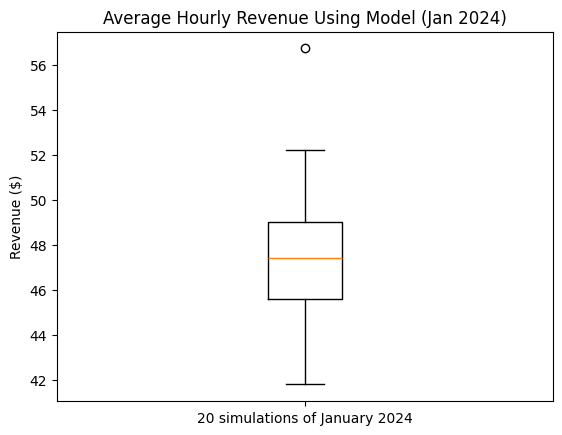

In [8]:
import matplotlib.pyplot as plt

revenues = [52.23, 41.79, 46.56, 56.75, 47.51,
            45.76, 44.09, 48.67, 51.49, 45.76,
            47.29, 49.27, 44.89, 49.37, 45.04,
            46.75, 47.60, 45.08, 48.97, 47.54]


plt.figure()
plt.boxplot(revenues, vert=True)
plt.title("Average Hourly Revenue Using Model (Jan 2024)")
plt.ylabel("Revenue ($)")
plt.xticks([1], ["20 simulations of January 2024"])
plt.show()




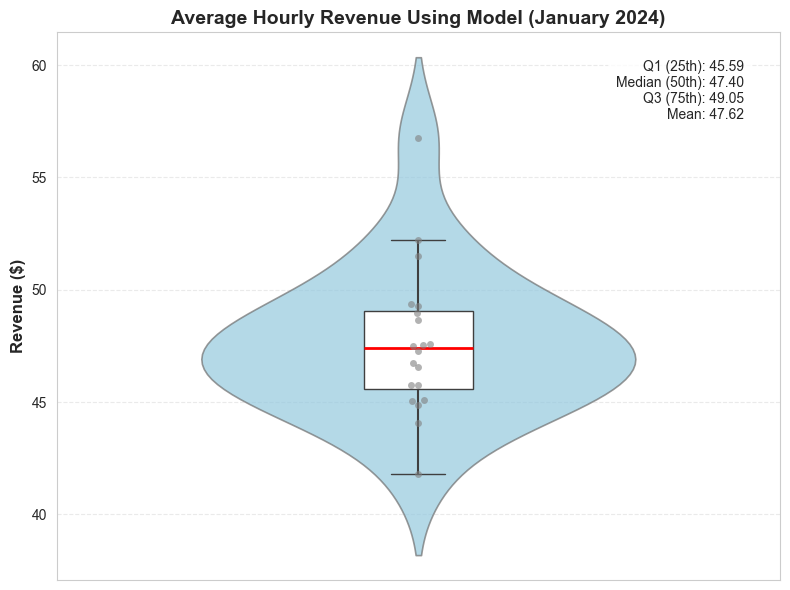

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

revenues = [52.23, 41.79, 46.56, 56.75, 47.51,
            45.76, 44.09, 48.67, 51.49, 45.76,
            47.29, 49.27, 44.89, 49.37, 45.04,
            46.75, 47.60, 45.08, 48.97, 47.54]

data = np.array(revenues)

q1, median, q3 = np.percentile(data, [25, 50, 75])
mean = np.mean(data)

stats_text = (
    f"Q1 (25th): {q1:.2f}\n"
    f"Median (50th): {median:.2f}\n"
    f"Q3 (75th): {q3:.2f}\n"
    f"Mean: {mean:.2f}"
)

bbox_props = dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

sns.violinplot(
    y=data,
    inner=None,
    width=0.6,
    linewidth=1.2,
    color="skyblue",
    alpha=0.7,
    ax=ax
)

sns.boxplot(
    y=data,
    width=0.15,
    showcaps=True,
    boxprops={'facecolor':'white', 'zorder':2},
    showfliers=False,
    whiskerprops={'linewidth':1.5},
    medianprops={'color':'red', 'linewidth':2},
    ax=ax
)

sns.swarmplot(
    y=data,
    size=5,
    color="gray",
    alpha=0.6,
    ax=ax
)

ax.set_ylabel("Revenue ($)", fontsize=12, fontweight='bold')
ax.set_title("Average Hourly Revenue Using Model (January 2024)", fontsize=14, fontweight='bold')

ax.set_xticks([])

ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

ax.text(
    0.95, 0.95,
    stats_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=bbox_props
)

plt.tight_layout()
plt.show()


In [ ]:
import json
import re

#Load the existing JSON file
with open('parametersOptimal.json', 'r', encoding='utf-8') as jf:
    data = json.load(jf)

# Build a lookup by zone
data_by_zone = { entry['zone']: entry for entry in data }

#Read the TXT output
with open('parametersfromRv2.txt', 'r', encoding='utf-8') as tf:
    txt = tf.read()

#Regex to find each non‐skipped “Model for Zone X” block
block_pattern = re.compile(
    r'Model for Zone (\d+)\s*:\s*'
    r'Series:\s*(\S+)\s*'
    r'(.+?)\s*'                              
    r'sigma\^2\s*=\s*([-\d.Ee]+)\s*:\s*'     
    r'log likelihood\s*=\s*([-\d.Ee]+)\s*'
    r'AIC\s*=\s*([-\d.Ee]+)\s*'
    r'AICc\s*=\s*([-\d.Ee]+)\s*'
    r'BIC\s*=\s*([-\d.Ee]+)',
    re.DOTALL
)

#helper to parse “lines of key  value”
def parse_kv_section(section_text):
    d = {}
    for line in section_text.splitlines():
        line = line.strip()
        if not line:
            continue
        m = re.match(r'([A-Za-z0-9_]+)\s+(-?\d*\.?\d+(?:[Ee][+-]?\d+)?)', line)
        if m:
            key, val = m.group(1), m.group(2)
            d[key] = float(val)
    return d

for m in block_pattern.finditer(txt):
    zone        = int(m.group(1))
    series      = m.group(2)
    middle      = m.group(3)
    sigma2      = float(m.group(4))
    ll          = float(m.group(5))
    aic, aicc, bic = map(float, m.group(6,7,8))

    # split out the Coefficients: … and the s.e.: … parts
    coeff_text = re.search(r'Coefficients:\s*(.*?)\s*s\.e\.', middle, re.DOTALL).group(1)
    se_text    = re.search(r's\.e\.\s*(.*?)$', middle,         re.DOTALL).group(1)

    coeffs    = parse_kv_section(coeff_text)
    std_errs  = parse_kv_section(se_text)

    # first line of middle is the model string
    model_spec = middle.strip().splitlines()[0]

    # construct new entry
    new_entry = {
        "zone": zone,
        "series": series,
        "model": model_spec,
        "coefficients": coeffs,
        "std_errors": std_errs,
        "sigma2": sigma2,
        "log_likelihood": ll,
        "AIC": aic,
        "AICc": aicc,
        "BIC": bic
    }

    data_by_zone[zone] = new_entry

#Write out updated JSON
updated = list(data_by_zone.values())
with open('parametersOptimal_updated.json', 'w', encoding='utf-8') as out:
    json.dump(updated, out, indent=2, ensure_ascii=False)

print("Wrote parametersOptimal_updated.json with all processed zones.") 



Wrote parametersOptimal_updated.json with all processed zones.
